# Simulating Power Rankings



/usr/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


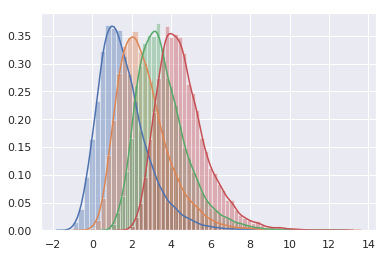

In [6]:
%matplotlib inline
from numpy.random import gumbel
import seaborn as sns
import numpy as np
sns.set()

# Creating actual values
latent_power_rankings = np.array([1, 2, 3, 4])

#simulate rankings
latent_strengths = np.zeros((10000, 4))
for latent_power_ranking_index in range(latent_power_rankings.shape[0]):
    latent_strengths[:, latent_power_ranking_index] = gumbel(loc=latent_power_rankings[latent_power_ranking_index], size=10000)
    sns.distplot(latent_strengths[:, latent_power_ranking_index])

In [10]:
# compute actual win win rate matrix

actual_win_rate_matrix = np.zeros((4,4))
for latent_power_ranking_index in range(latent_power_rankings.shape[0]):
    for latent_power_ranking_index2 in [latent_power_ranking_index2 for latent_power_ranking_index2 in range(latent_power_rankings.shape[0]) if latent_power_ranking_index2 != latent_power_ranking_index]:
        actual_win_rate_matrix[latent_power_ranking_index, latent_power_ranking_index2] = np.sum(latent_strengths[:, latent_power_ranking_index] > latent_strengths[:, latent_power_ranking_index2])/latent_strengths.shape[0]
        
actual_win_rate_matrix

array([[0.    , 0.2697, 0.1183, 0.0498],
       [0.7303, 0.    , 0.2714, 0.1263],
       [0.8817, 0.7286, 0.    , 0.2691],
       [0.9502, 0.8737, 0.7309, 0.    ]])

In [20]:
#probability matrix of each player beating each other -- remove all self-comparisons

win_matrix = np.zeros((4,4))
matches_matrix = np.zeros((4,4))

match_num = 0
while match_num < 8000:
    for latent_power_ranking_index in range(latent_power_rankings.shape[0]):
        for latent_power_ranking_index2 in [latent_power_ranking_index2 for latent_power_ranking_index2 in range(latent_power_rankings.shape[0]) if latent_power_ranking_index2 != latent_power_ranking_index]:
            matches_matrix[latent_power_ranking_index, latent_power_ranking_index2] += 1
            matches_matrix[latent_power_ranking_index2, latent_power_ranking_index] += 1
            if latent_strengths[match_num, latent_power_ranking_index] > latent_strengths[match_num, latent_power_ranking_index2]:
                win_matrix[latent_power_ranking_index, latent_power_ranking_index2] += 1
            elif latent_strengths[match_num, latent_power_ranking_index] < latent_strengths[match_num, latent_power_ranking_index2]:
                win_matrix[latent_power_ranking_index2, latent_power_ranking_index] += 1
            
            match_num += 1

win_matrix / matches_matrix

array([[       nan, 0.26386807, 0.11244378, 0.05997001],
       [0.73613193,        nan, 0.26911544, 0.11394303],
       [0.88755622, 0.73088456,        nan, 0.27211394],
       [0.94002999, 0.88605697, 0.72788606,        nan]])

In [ ]:
import pymc3 as pm
import theano.tensor as tt

total_wins = np.sum(win_matrix, axis=1)
comparison_matrix = np.triu(matches_matrix)

observed = {'total_wins': total_wins,
            'comparison_matrix': comparison_matrix}

with pm.Model() as model:
    # latent strengths
    #l = pm.Gumbel('latent_power', mu=1, beta=10, shape=4) # change to 3 or 4 depending on logp
    l = pm.Logistic('latent_power', mu=0, s=1, shape=4)
    # consider putting a single ravel statement here
    
    #def logp(total_wins, comparison_matrix):
    #    lp_pairs = tt.triu(tt.tile(l, 4).reshape((4,4)) + tt.tile(l, 4).reshape((4,4)).T, k=1).nonzero_values()
    #    num_comparisons = comparison_matrix.ravel().nonzero_values()
    #    return tt.sum(total_wins * tt.log(l)) - tt.sum(num_comparisons * tt.log(lp_pairs))
    
    def logp(total_wins, comparison_matrix):
        lp_pairs = tt.triu(tt.tile(l, 4).reshape((4,4)) + tt.tile(l, 4).reshape((4,4)).T, k=1).nonzero_values()
        num_comparisons = comparison_matrix.ravel().nonzero_values()
        return tt.sum(total_wins * l) - tt.sum(num_comparisons * lp_pairs)
    
    #def logp(total_wins, comparison_matrix):
    #    l_x = tt.concatenate([[0], l])
    #    lp_pairs = tt.triu(tt.tile(l_x, 4).reshape((4,4)) + tt.tile(l_x, 4).reshape((4,4)).T, k=1).nonzero_values()
    #    num_comparisons = comparison_matrix.ravel().nonzero_values()
    #    return tt.sum(total_wins * l_x) - tt.sum(num_comparisons * lp_pairs)
    
    like = pm.DensityDist('like', logp, observed=observed)
    trace = pm.sample(10000, tune=5000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f02dc6f4a20>,
      dtype=object)

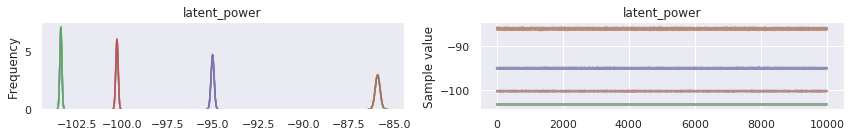

In [55]:
pm.traceplot(trace)

In [56]:
win_matrix / matches_matrix

array([[       nan, 0.26386807, 0.11244378, 0.05997001],
       [0.73613193,        nan, 0.26911544, 0.11394303],
       [0.88755622, 0.73088456,        nan, 0.27211394],
       [0.94002999, 0.88605697, 0.72788606,        nan]])

/usr/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


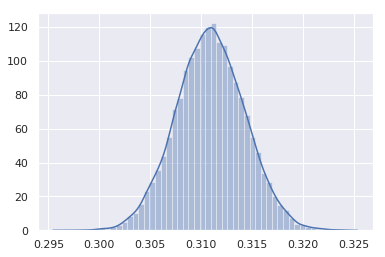

In [57]:
def normalize(matrix):
    new_matrix = (matrix - np.mean(matrix))/np.std(matrix)
    return new_matrix

def logistic(samples1, samples2):
    return np.exp(samples1)/(np.exp(samples1) + np.exp(samples2))

test = normalize(trace['latent_power'])

#sns.distplot(logistic(trace['latent_power'][:,3], trace['latent_power'][:,0]))
sns.distplot(logistic(test[:,1], test[:,2]))

[-1.34164079 -0.4472136   0.4472136   1.34164079]


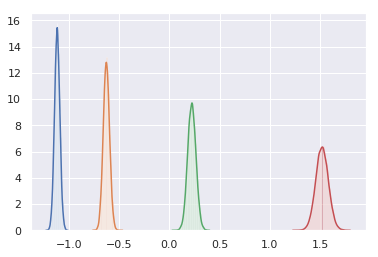

In [324]:
print(normalize(latent_power_rankings))

for x in range(4):
    sns.distplot(test[:,x])